In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np


import os
print(os.listdir("../input/hindiletters/Hindi letters/"))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['ब', 'न', 'ई', 'य', 'ण', 'आ', 'ल', 'छ', 'ऋ', 'ष', 'त्र', 'भ', 'च', 'ट', 'त', 'इ', 'ज', 'ह', 'उ', 'म', 'व', 'ढ', 'अ', 'ग', 'प', 'ऊ', 'ऐ', 'ध', 'द', 'ठ', 'ङ', 'क', 'औ', 'थ', 'ए', 'ओ', 'घ', 'श', 'फ', 'ञ', 'ज्ञ', 'झ', 'क्ष', 'ड', 'स', 'र', 'ख']


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocessing,
        validation_split = 0.1,
    )
    
    
    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        '../input/hindiletters/Hindi letters/',
        target_size = (height, width), 
        classes = ('ड', 'ढ', 'ई', 'झ', 'ङ', 'व', 'थ', 'भ', 'ब', 'ल', 'च',
                   'ओ', 'औ', 'अ', 'ऋ', 'स', 'ए', 'प', 'ञ', 'फ', 'ध', 'ह',
                   'ऊ', 'ज्ञ', 'ण', 'ज', 'आ', 'न', 'उ', 'क', 'म', 'ऐ', 'य', 
                   'ट', 'ग', 'घ', 'द', 'श', 'क्ष', 'र', 'त', 'ठ', 'ष', 'ख', 'त्र', 'इ', 'छ'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        '../input/hindiletters/Hindi letters/',
        target_size = (height, width), 
        classes = ('ड', 'ढ', 'ई', 'झ', 'ङ', 'व', 'थ', 'भ', 'ब', 'ल', 'च',
                   'ओ', 'औ', 'अ', 'ऋ', 'स', 'ए', 'प', 'ञ', 'फ', 'ध', 'ह',
                   'ऊ', 'ज्ञ', 'ण', 'ज', 'आ', 'न', 'उ', 'क', 'म', 'ऐ', 'य', 
                   'ट', 'ग', 'घ', 'द', 'श', 'क्ष', 'र', 'त', 'ठ', 'ष', 'ख', 'त्र', 'इ', 'छ'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [3]:
vgg = keras.applications.vgg16

In [4]:
train_dataset, val_dataset = generators((256,256), preprocessing=vgg.preprocess_input)

Found 4240 images belonging to 47 classes.
Found 468 images belonging to 47 classes.


In [5]:
vgg_conv = vgg.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [6]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4a35f3ccd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a624f0bd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a61c8ec90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4a310e3390> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a31105c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a311053d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4a31112ed0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a30c3b150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a30c3ea10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a30c45ad0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4a30c4db50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [7]:
# Create the model
model = keras.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(47, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 47)                48175     
Total params: 48,318,319
Trainable params: 40,683,055
Non-trainable params: 7,635,264
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("../working/model.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_dataset,
      steps_per_epoch=train_dataset.samples/batch_size ,
      epochs=20,
      validation_data=val_dataset,
      validation_steps=val_dataset.samples/batch_size,
      verbose=1,
      callbacks=[checkpoint])

Epoch 1/20
133/132 [==============================] - ETA: 0s - loss: 3.0546 - acc: 0.2000
Epoch 00001: val_acc improved from -inf to 0.47650, saving model to ../working/model.h5
133/132 [==============================] - 84s 635ms/step - loss: 3.0546 - acc: 0.2000 - val_loss: 1.7149 - val_acc: 0.4765
Epoch 2/20
133/132 [==============================] - ETA: 0s - loss: 1.1383 - acc: 0.6491
Epoch 00002: val_acc improved from 0.47650 to 0.76923, saving model to ../working/model.h5
133/132 [==============================] - 81s 613ms/step - loss: 1.1383 - acc: 0.6491 - val_loss: 0.7707 - val_acc: 0.7692
Epoch 3/20
133/132 [==============================] - ETA: 0s - loss: 0.4820 - acc: 0.8479
Epoch 00003: val_acc improved from 0.76923 to 0.82906, saving model to ../working/model.h5
133/132 [==============================] - 81s 608ms/step - loss: 0.4820 - acc: 0.8479 - val_loss: 0.5721 - val_acc: 0.8291
Epoch 4/20
133/132 [==============================] - ETA: 0s - loss: 0.2500 - acc: 0

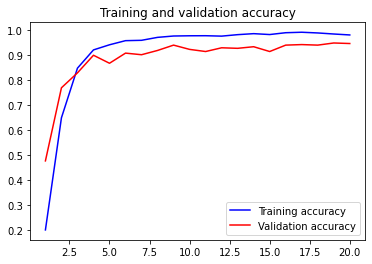

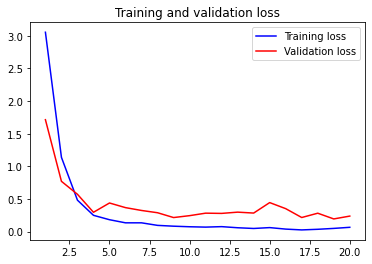

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')
